[['fp_time', 'cmp_time', 'index_time'], ['table_time'], ['io_time'], ['fs_time'], ['other_time']]
[0.8, 1.2, 1.8, 2.2, 2.8, 3.2, 3.8, 4.2]
[0.8, 1.2, 1.8, 2.2, 2.8, 3.2, 3.8, 4.2]
[['fp_time', 'cmp_time', 'index_time'], ['table_time'], ['io_time'], ['fs_time'], ['other_time']]
[['fp_time', 'cmp_time', 'index_time'], ['table_time'], ['io_time'], ['fs_time'], ['other_time']]
[0.8, 1.2, 1.8, 2.2, 2.8, 3.2, 3.8, 4.2]
[0.8, 1.2, 1.8, 2.2, 2.8, 3.2, 3.8, 4.2]
[['fp_time', 'cmp_time', 'index_time'], ['table_time'], ['io_time'], ['fs_time'], ['other_time']]
16


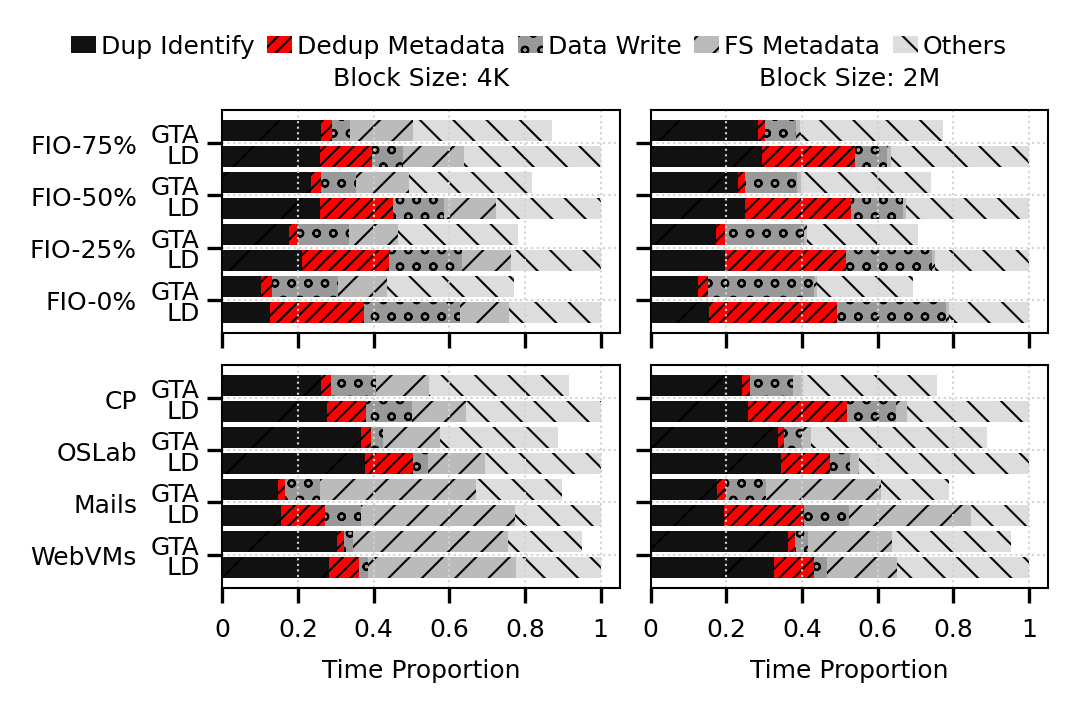

In [1]:
# ipython -c "%run plot.ipynb"

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table-fio", "r") as f:
    df_fio = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')
with open("./performance-comparison-table-real", "r") as f:
    df_real = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(5.5)))
fig.patch.set_facecolor('white')

bar_width = 0.5
true_width = 0.4
num_job = 1

patterns = ['/', '', 'ooo', "///", "\\\\\\", "xxx"]

breakdown_times = [["fp_time", "cmp_time"], ["index_time", "table_time"], ["io_time"], ["fs_time"]]

blks = [1, 512]
blks_fio = ['4K', '2M']

bars = []
global_color_idx = 0
color_map = {}
# grayscale colors
colors = ["#111111", "#555555", "#999999", "#BBBBBB", "#DDDDDD", "#FFFFFF"]

for df_idx, df in enumerate([df_fio, df_real]):
    for blk_idx, blk in enumerate(blks):
        if df is df_fio:
            real_bs = blks_fio[blk_idx]
            workload_map = {
                0: [],
                25: [],
                50: [],
                75: [],
            }
            workload_kw = "dup_rate"
            workloads = [ 0, 25, 50, 75 ]
            workloads_rename = ["FIO-0%", "FIO-25%", "FIO-50%", "FIO-75%"]
        else:
            real_bs = blk * 4096
            workload_map = {
                "cp": [],
                "homes-2022-fall-50.hitsztrace": [],
                "webmail+online.cs.fiu.edu-110108-113008.1-21.blkparse": [],
                "cheetah.cs.fiu.edu-110108-113008.1.blkparse": [],
            }
            workload_kw = "workload"
            workloads = [ "cp", "homes-2022-fall-50.hitsztrace", "webmail+online.cs.fiu.edu-110108-113008.1-21.blkparse", "cheetah.cs.fiu.edu-110108-113008.1.blkparse" ]
            workloads_rename = ["CP", "OSLab", "Mails", "WebVMs"]
            # workloads = ["write", "webproxy.f"]
            # workloads_remap = ["SW", "WPX"]

            workloads.reverse()
            workloads_rename.reverse()
            
        fss = df['system'].drop_duplicates().reset_index().drop(columns=['index'])['system']
        breakdown_times = [["fp_time", "cmp_time", "index_time"], ["table_time"], ["io_time"], ["fs_time"], ["other_time"]]
        fss = pd.Series(["Light-Dedup-Improve", "Light-Dedup-J-64bits"])
        
        print(breakdown_times)
        
        x = list(range(1, len(workloads) + 1))
        
        fid = df_idx * len(blks) + blk_idx
        subfig = plt.subplot(2, 2, fid + 1) 
        # ax2 = subfig.twinx()
        pivots = []
        for fs_idx, fs in enumerate(fss):
            for workload_id, workload in enumerate(workloads):
                total_time = 0
                for idx, time in enumerate(breakdown_times):
                    width = 0
                    for t in time:
                        width += df[(df[workload_kw] == workload) & (df['system'] == fs) & (df['bs'] == real_bs)][t].iloc[0] / 1000000000
                    total_time += width
                workload_map[workload].append(total_time)
        
        for fs_idx, fs in enumerate(fss):
            for workload_id, workload in enumerate(workloads):
                color_idx = 0
                left = 0
                pivot = x[workload_id] - len(fss) * bar_width / 2 + bar_width / 2 + fs_idx * bar_width 
                pivots.append(pivot)
                
                inner_left = 0
                inner_left_range = []
                start = False
                for idx, time in enumerate(breakdown_times):
                    width = 0
                    for t in time:
                        width += df[(df[workload_kw] == workload) & (df['system'] == fs) & (df['bs'] == real_bs)][t].iloc[0] / 1000000000 / max(workload_map[workload]) 
                    
                    if idx == 1:
                        bar, = subfig.barh(y=pivot, width=width, left=left, height=true_width, color="red",linewidth=0.5, label=time, hatch="///////")
                    else:
                        bar, = subfig.barh(y=pivot, width=width, left=left, height=true_width, color=colors[color_idx], hatch=patterns[idx],linewidth=0.5, label=time)
                    left = left + width 
                    
                    if fid == 0:
                        if workload_id == 0:
                            bars.append(bar)
                    else:
                        if workload_id == 0:
                            if idx not in [0, 1, 3, 4]:
                                bars.append(bar)
                    color_idx += 1
        
        subfig.set_xlim([0, 1.05])
        subfig.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1], minor=False)
        subfig.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=6)
        if fid >= 2:
            subfig.set_xlabel("Time Proportion", fontsize=6)
        else:
            subfig.set_xticklabels([], fontsize=6)
            subfig.set_title(f"Block Size: {real_bs}", fontsize=6)
            
        subfig.set_yticks(x, minor=False)
        if fid % 2 == 0:
            subfig.set_yticklabels(workloads_rename, fontsize=6, minor=False)
            fss = fss.map({
                "Light-Dedup-J-64bits": "GTA",
                "Light-Dedup-Improve": "LD",
            })
            yticklabels = list(fss)
            yticklabels = yticklabels * len(workloads)
            pivots.sort()
            pivots = [ round(pivot, 1) for pivot in pivots]
            pivots = [ pivot - 0.01 if pivot in x else pivot for pivot in pivots]
            print(pivots)
            subfig.set_yticks(pivots, minor=True)
            subfig.set_yticklabels(yticklabels, minor=True, fontsize=6)
            subfig.get_yaxis().set_tick_params(which='major', pad=17)
            print(pivots)
        else:
            subfig.set_yticklabels([], fontsize=6)
        
        ax = fig.gca()
        lw = 0.5
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
            
        subfig.tick_params(bottom=False, top=False, left=False, right=False, which='minor')
    
print(len(bars))

legends = ["Dup Identify", "Dedup Metadata", "Data Write", "FS Metadata", "Others"]
fig.legend(handles=bars, labels=legends, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.05), frameon=False, columnspacing=0.5, handletextpad=0.2, handlelength=1, borderpad=0.2, labelspacing=0.2, fontsize=6)

plt.tight_layout(pad=0.4)
plt.savefig("./FIG-DedupBreakdown.pdf", bbox_inches='tight', pad_inches=0)
